In [12]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [13]:
img = cv2.imread('/mnt/d/565/hw1/waterfall.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

In [14]:
img_ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = img_ycbcr[:, :, 0]
Cb = img_ycbcr[:, :, 1]
Cr = img_ycbcr[:, :, 2]

Cb_sub = Cb[::2, ::2]
Cr_sub = Cr[::2, ::2]

In [15]:
Cb_up_nearest = np.zeros_like(Cb)
Cr_up_nearest = np.zeros_like(Cr)

for row in range(0, Cb.shape[0], 2):
    for col in range(0, Cb.shape[1], 2):
        Cb_up_nearest[row, col] = Cb_sub[row // 2, col // 2]
        Cr_up_nearest[row, col] = Cr_sub[row // 2, col // 2]
        
        if col + 1 < Cb.shape[1]:
            Cb_up_nearest[row, col + 1] = Cb_up_nearest[row, col]
            Cr_up_nearest[row, col + 1] = Cr_up_nearest[row, col]

for row in range(1, Cb.shape[0], 2):
    Cb_up_nearest[row, :] = Cb_up_nearest[row - 1, :]
    Cr_up_nearest[row, :] = Cr_up_nearest[row - 1, :]

ycbcr_recon_nearest = cv2.merge((Y, Cb_up_nearest, Cr_up_nearest))
rgb_recon_nearest = cv2.cvtColor(ycbcr_recon_nearest, cv2.COLOR_YCrCb2RGB)

In [16]:
def bicubic_weight(x):
    x = abs(x)
    if x <= 1:
        return 1.5 * x**3 - 2.5 * x**2 + 1
    elif x < 2:
        return -0.5 * x**3 + 2.5 * x**2 - 4 * x + 2
    else:
        return 0

Cb_up_bicubic = np.zeros_like(Cb, dtype=np.float64)
Cr_up_bicubic = np.zeros_like(Cr, dtype=np.float64)

for i in range(Cb.shape[0]):
    for j in range(Cb.shape[1]):
        row = int(i / 2)
        col = int(j / 2)
        
        Cb_neighbors = Cb_sub[max(row-1, 0):min(row+3, Cb_sub.shape[0]), max(col-1, 0):min(col+3, Cb_sub.shape[1])]
        weight_sum = 0
        value_sum = 0
        
        for ni in range(-1, 3):
            for nj in range(-1, 3):
                x_dist = i / 2 - (row + ni)
                y_dist = j / 2 - (col + nj)
                
                if 0 <= row + ni < Cb_sub.shape[0] and 0 <= col + nj < Cb_sub.shape[1]:
                    w = bicubic_weight(x_dist) * bicubic_weight(y_dist)
                    weight_sum += w
                    value_sum += Cb_sub[row + ni, col + nj] * w
        
        Cb_up_bicubic[i, j] = value_sum / weight_sum if weight_sum != 0 else 0

        Cr_neighbors = Cr_sub[max(row-1, 0):min(row+3, Cr_sub.shape[0]), max(col-1, 0):min(col+3, Cr_sub.shape[1])]
        weight_sum = 0
        value_sum = 0
        
        for ni in range(-1, 3):
            for nj in range(-1, 3):
                x_dist = i / 2 - (row + ni)
                y_dist = j / 2 - (col + nj)
                
                if 0 <= row + ni < Cr_sub.shape[0] and 0 <= col + nj < Cr_sub.shape[1]:
                    w = bicubic_weight(x_dist) * bicubic_weight(y_dist)
                    weight_sum += w
                    value_sum += Cr_sub[row + ni, col + nj] * w

        Cr_up_bicubic[i, j] = value_sum / weight_sum if weight_sum != 0 else 0

ycbcr_recon_bicubic = cv2.merge((Y.astype(np.uint8), Cb_up_bicubic.astype(np.uint8), Cr_up_bicubic.astype(np.uint8)))
rgb_recon_bicubic = cv2.cvtColor(ycbcr_recon_bicubic, cv2.COLOR_YCrCb2RGB)


In [18]:
img = img_rgb.astype(np.float64)
rgb_recon_nearest = rgb_recon_nearest.astype(np.float64)
rgb_recon_bicubic = rgb_recon_bicubic.astype(np.float64)

mse_nearest = np.mean((img - rgb_recon_nearest) ** 2)
mse_bicubic = np.mean((img - rgb_recon_bicubic) ** 2)

print(f'MSE with nearest-neighbor upsampling: {mse_nearest}')
print(f'MSE with bicubic interpolation: {mse_bicubic}')

MSE with nearest-neighbor upsampling: 1.8671256510416667
MSE with bicubic interpolation: 0.5842230902777777


Text(0.5, 1.0, 'Original Image')

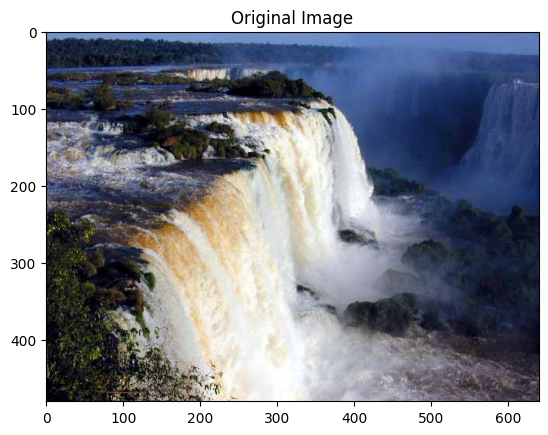

In [27]:
plt.figure()
plt.imshow(img_rgb.astype(np.uint8))
plt.title('Original Image')

Text(0.5, 1.0, 'Reconstructed Image with Nearest Neighbor Upsampling')

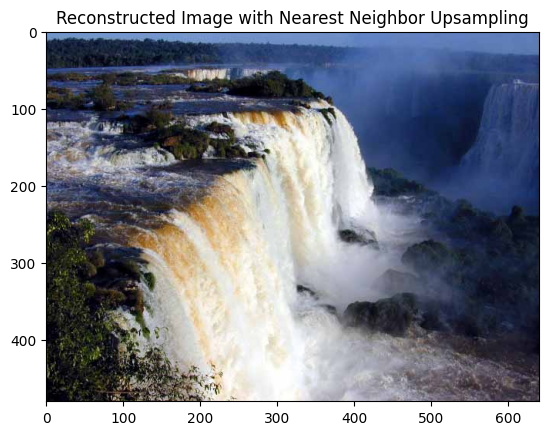

In [26]:
plt.figure()
plt.imshow(rgb_recon_nearest.astype(np.uint8))
plt.title('Reconstructed Image with Nearest Neighbor Upsampling')

Text(0.5, 1.0, 'Reconstructed Image with Bicubic Interpolation')

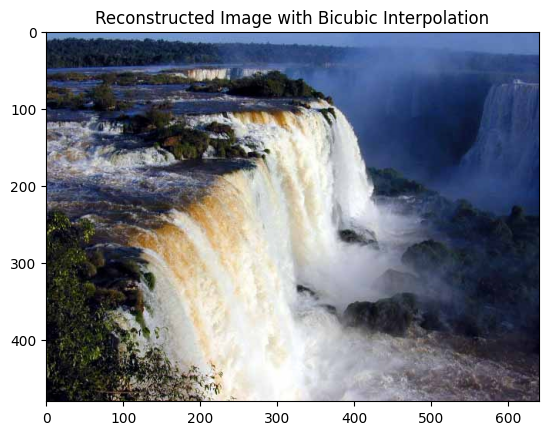

In [25]:
plt.figure()
plt.imshow(rgb_recon_bicubic.astype(np.uint8))
plt.title('Reconstructed Image with Bicubic Interpolation')